In [72]:
from google.colab import files
import pandas as pd
import io
from random import sample, choices
import random
import numpy as np
import statistics
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import math


In [2]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['bid_data.csv']))

df


Saving bid_data.csv to bid_data.csv


,What is your bid when your value is 10?,What is your bid when your value is 20?,What is your bid when your value is 30?,What is your bid when your value is 40?,What is your bid when your value is 50?,What is your bid when your value is 60?,What is your bid when your value is 70?,What is your bid when your value is 80?,What is your bid when your value is 90?,What is your bid when your value is 100?
0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0
1,8.0,16.0,25.0,33.0,41.0,50.0,59.0,69.0,79.0,91.0
2,9.0,17.0,24.0,31.0,38.0,45.0,52.0,59.0,66.0,73.0
3,10.0,10.0,20.0,20.0,30.0,30.0,40.0,40.0,50.0,60.0
4,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0
5,9.0,18.0,28.0,38.0,47.0,56.0,65.0,74.0,83.0,92.0
6,8.0,16.0,24.0,32.0,40.0,48.0,56.0,70.0,80.0,85.0
7,0.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,51.0
8,10.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0
9,9.0,16.0,25.0,34.0,42.0,53.0,61.0,74.0,82.0,92.0


In [125]:
# gathers input file data
all_data=[]
df = pd.read_csv(io.BytesIO(uploaded['bid_data.csv']))
df = df.values.tolist()
for x in df:
  for y in x:
    all_data.append(y)


In [126]:
num_samples = 1000
def win_bid(competitor_bid, your_bid):
  if your_bid > competitor_bid:
    return 1
  elif your_bid == competitor_bid:
    return 1 if random.uniform(0, 1) > 0.5 else 0
  return 0


In [127]:
# the different strategies tested
def get_emperical(data, value, alpha=0.5):
  mean = statistics.mean(data)
  if len(data)>1:
    std = statistics.stdev(data)
  else:
    std = mean/2
  return min(value, mean+alpha*std/math.sqrt(len(data)))


def get_best(data,value):
  max_utility=0
  best_bid=0
  for p_b in range(0,value*10):
    potential_bid=p_b/10
    win_mask = [win_bid(x, potential_bid) for x in data]
    num_wins = sum(win_mask)
    win_prob = num_wins / num_samples
    expected_utility = win_prob*(value-potential_bid)
    if(expected_utility>max_utility):
      max_utility=expected_utility
      best_bid=potential_bid
  return best_bid

def mixed(data, value, b1, b2, epsilon=0.01):
  ep=epsilon*len(data)
  return (b1*(1-ep)+b2*ep)
  # return (b1+b2)/2

def get_bids(value, data):
  noise=(value*(1+0.05))/2
  return [
      ("uniform",value/2),
      ("uniform-biased",noise),
        ("emperical",get_emperical(data, value,alpha=1.96)),
         ("emperical-high-risk",get_emperical(data, value, alpha=1)),
          ("emperical-low-risk",get_emperical(data, value, alpha=2.5)),
      ("best_subset", get_best(data, value)),
      ("mixed", mixed(data, value, noise, get_best(data, value)))
      ]

def get_oracle(data):
  max_bids={}
  max_utility={}
  for v in range(10,110,10):
    max_bids[v]=0
    max_utility[v]=0

  for p_b in range(0,100*10):
    potential_bid=p_b/10
    win_mask = [win_bid(x, potential_bid) for x in data]
    num_wins = sum(win_mask)
    win_prob = num_wins / num_samples

    for value in range(10,110,10):
      if potential_bid>value:
        continue
      expected_utility = win_prob*(value-potential_bid)
      if(expected_utility>max_utility[value]):
        max_utility[value]=expected_utility
        max_bids[value]=potential_bid

  return max_bids


In [157]:
# get data for synthetic and real world experiment
def get_data(synthetic=False):
  all_data=[]
  df = pd.read_csv(io.BytesIO(uploaded['bid_data.csv']))
  df = df.values.tolist()
  for x in df:
    for y in x:
      all_data.append(y)
  if not synthetic:
    return all_data
  means=[]
  stds=[]
  for v in range(10,110, 10):
    means.append(random.random()*v)
    stds.append(random.random()*10)

  for i in range(len(all_data)):
    v=int(random.random()*9)
    all_data[i]=min(max(0,np.random.normal(means[v],stds[v])),(v+1)*100)
  return all_data



In [158]:
# script to run experiments
trials = 100
synth=True
all_outputs = []

for _ in range(trials):
  outputs={"n": [], "value": []}

  for train_n in [1, 20, 50, 100]:

    all_data = get_data(synth)

    msk = np.zeros(len(all_data), dtype=bool)
    msk[np.random.choice(len(all_data), train_n, replace=False)] = True

    data = []
    competitor_df = []

    for i, val in enumerate(msk):
      if(val):
        data.append(all_data[i])
      else:
        competitor_df.append(all_data[i])

    sampled_competitor_bids = []
    for i in range(num_samples):
      sampled_competitor_bids.append(random.choice(competitor_df))

    optimal=get_oracle(sampled_competitor_bids)

    for value in range(10,110,10):
      outputs["n"].append(train_n)
      outputs["value"].append(value)

      potential_bids=get_bids(value, data)
      potential_bids.append(("oracle",optimal[value]))

      for label, potential_bid in potential_bids:
        # compute win probability
        win_mask = [win_bid(x, potential_bid) for x in sampled_competitor_bids]
        num_wins = sum(win_mask)
        win_prob = num_wins / num_samples
        expected_utility = win_prob*(value-potential_bid)
        if label in outputs:
          outputs[label].append(expected_utility)
          outputs[label+"_bid"].append(potential_bid)
          outputs[label+"_p"].append(win_prob)
        else:
          outputs[label]=[expected_utility]
          outputs[label+"_bid"]=[potential_bid]
          outputs[label+"_p"]=[win_prob]

  all_outputs.append(outputs)

In [159]:
avg_data={}
for trial in range(trials):
  for ke in all_outputs[trial]:
    if ke not in avg_data:
      avg_data[ke]=[0]*len(all_outputs[trial][ke])
    for i in range(len(all_outputs[trial][ke])):
      avg_data[ke][i]+=1/trials*all_outputs[trial][ke][i]


In [160]:
df=pd.DataFrame(avg_data)
df["n"]=round(df["n"]).astype(int)
df["value"]=round(df["value"]).astype(int)
df

,n,value,uniform,uniform_bid,uniform_p,uniform-biased,uniform-biased_bid,uniform-biased_p,emperical,emperical_bid,...,emperical-low-risk_p,best_subset,best_subset_bid,best_subset_p,mixed,mixed_bid,mixed_p,oracle,oracle_bid,oracle_p
0,1,10,0.8459,5.0,0.16918,0.837900,5.25,0.17640,0.088052,9.354149,...,0.28686,0.440306,1.892,0.08694,0.840613,5.21642,0.17572,0.999932,4.060,0.17444
1,1,20,2.9976,10.0,0.29976,2.924670,10.50,0.30786,0.737929,16.915561,...,0.44082,1.568470,4.172,0.14646,2.937648,10.43674,0.30714,3.353138,7.708,0.28330
2,1,30,5.9079,15.0,0.39386,5.827395,15.75,0.40894,2.127676,23.011801,...,0.53300,3.305700,8.042,0.22776,5.833800,15.67296,0.40718,6.626406,11.852,0.37878
3,1,40,9.8268,20.0,0.49134,9.595760,21.00,0.50504,4.045057,28.212710,...,0.60016,5.739164,11.566,0.29124,9.629779,20.90566,0.50438,10.817608,16.314,0.46646
4,1,50,14.0720,25.0,0.56288,13.796850,26.25,0.58092,6.640273,32.608147,...,0.64956,8.950790,17.070,0.38276,13.818896,26.15820,0.57950,15.922998,20.306,0.54214
5,1,60,18.9720,30.0,0.63240,18.582000,31.50,0.65200,9.882688,36.266694,...,0.68004,12.816992,19.300,0.41754,18.634000,31.37800,0.65096,21.495944,22.396,0.57726
6,1,70,24.0961,35.0,0.68846,23.579570,36.75,0.70916,13.555629,39.396528,...,0.69698,17.070252,23.386,0.47254,23.632128,36.61632,0.70786,27.759264,26.394,0.65040
7,1,80,29.8104,40.0,0.74526,28.999320,42.00,0.76314,17.737616,42.030842,...,0.70538,21.798576,24.918,0.48872,29.091354,41.82916,0.76210,34.502914,29.406,0.69110
8,1,90,35.5671,45.0,0.79038,34.676235,47.25,0.81114,22.264227,44.267231,...,0.70864,26.613924,24.916,0.48792,34.809359,47.02668,0.81004,41.498604,31.266,0.71674
9,1,100,41.6850,50.0,0.83370,40.436750,52.50,0.85130,27.620150,45.714308,...,0.70882,31.339404,24.914,0.48638,40.563076,52.22416,0.84906,48.904138,34.704,0.75932


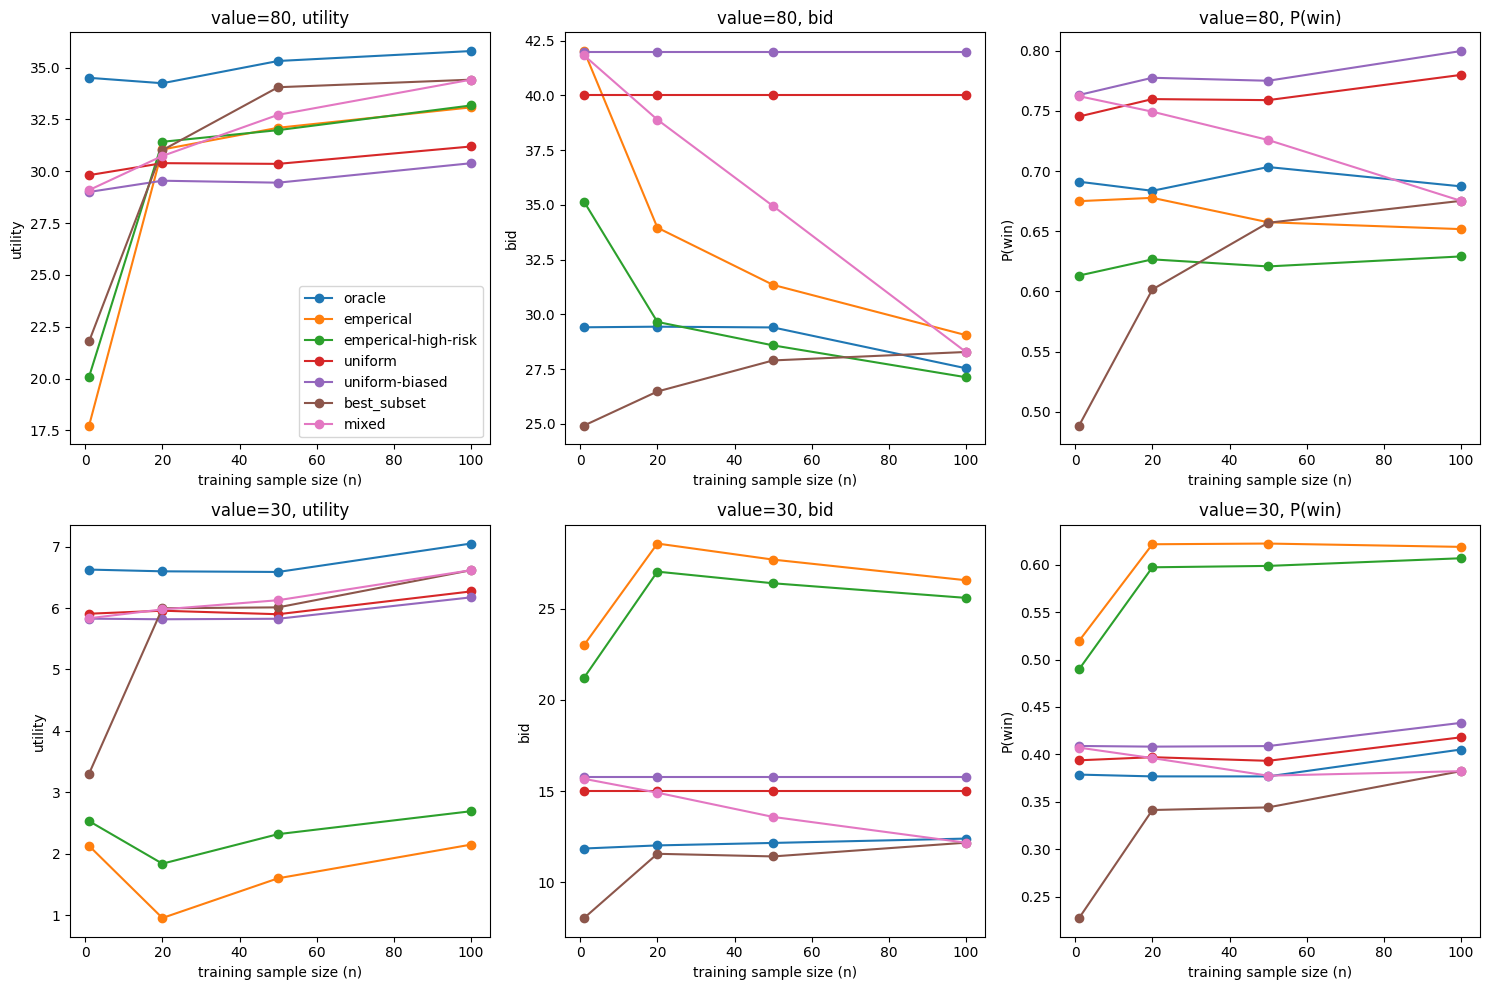

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Define types and suffs/labels as per your request
types = ["oracle", "emperical", "emperical-high-risk", "uniform", "uniform-biased", "best_subset", "mixed"]
suffs = ["", "_bid", "_p"]
labels = ["utility", "bid", "P(win)"]

# Plot for value == 80
for idx, (s, l) in enumerate(zip(suffs, labels)):
    temp = [tp + s for tp in types] + ["n"]
    ax = df[df["value"] == 80][temp].plot(
        x="n",
        marker='o',
        xlabel="training sample size (n)",
        ylabel=l,
        ax=axes[idx],
        title=f"value=80, {l}",
        legend=(idx == 0)  # Only display legend for the first plot
    )

# Plot for value == 30
for idx, s in enumerate(suffs):
    temp = [tp + s for tp in types] + ["n"]
    ax = df[df["value"] == 30][temp].plot(
        x="n",
        marker='o',
        xlabel="training sample size (n)",
        ylabel=labels[idx],
        ax=axes[idx + 3],
        title=f"value=30, {labels[idx]}",
        legend=False  # Disable the legend for these plots
    )

# Adjust layout
plt.tight_layout()
plt.show()

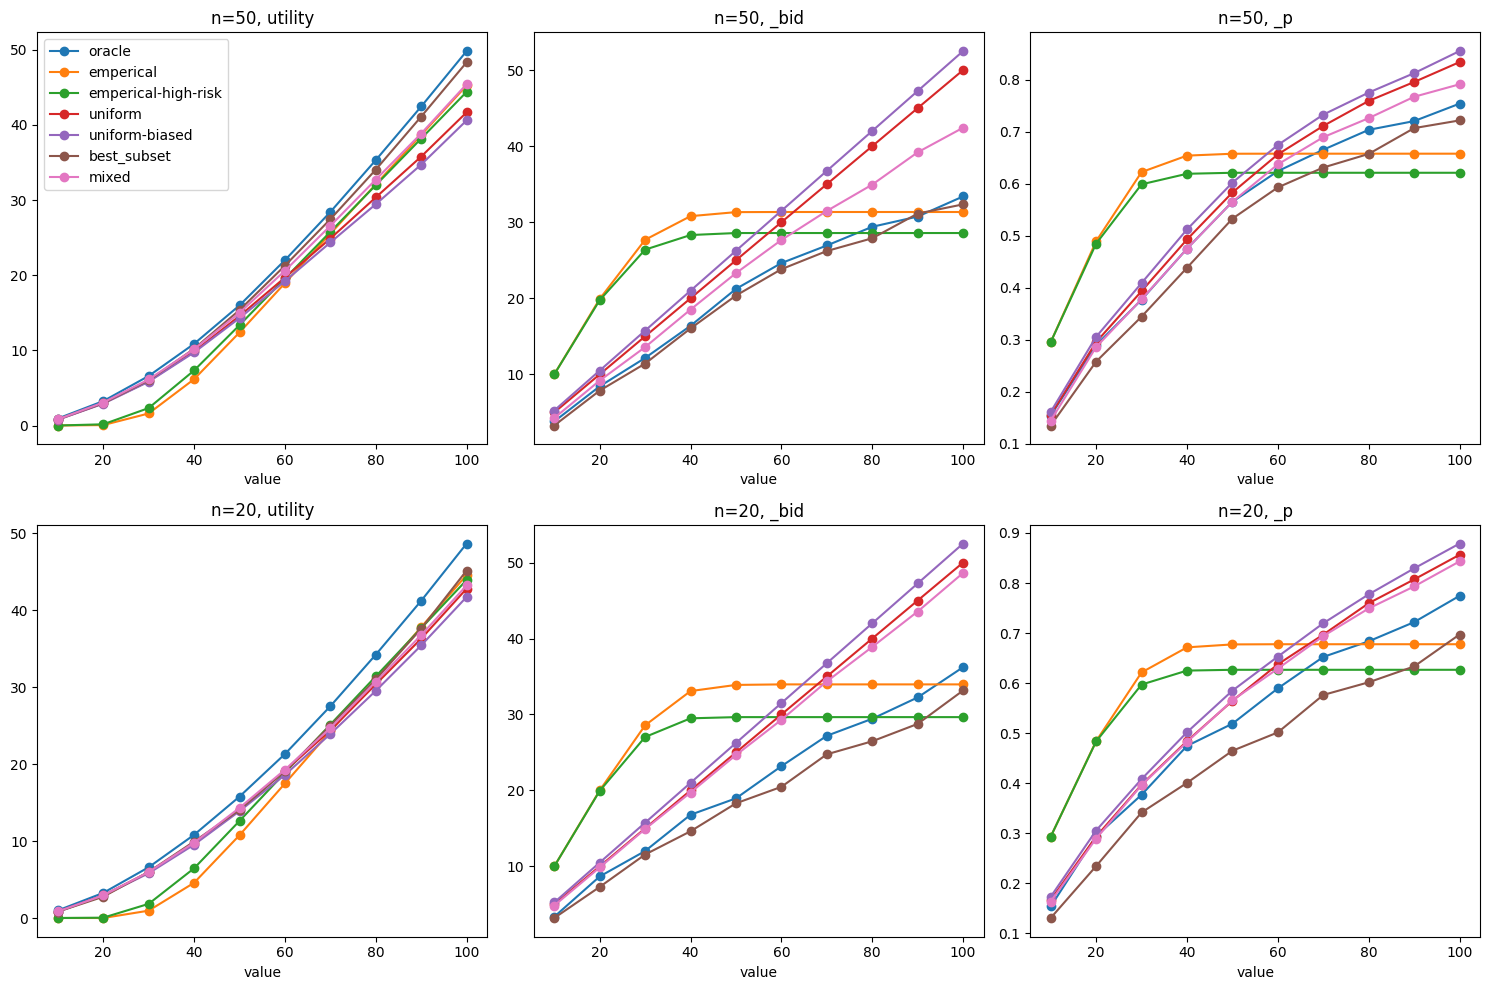

In [162]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Define types and suffs/labels as per your request
types = ["oracle", "emperical", "emperical-high-risk", "uniform", "uniform-biased", "best_subset", "mixed"]
suffs = ["", "_bid", "_p"]

# Plot for n == 50
for idx, s in enumerate(suffs):
    temp = [tp + s for tp in types] + ["value"]
    df[df["n"] == 50][temp].plot(
        x="value",
        marker='o',
        ax=axes[idx],
        title=f"n=50, {s if s else 'utility'}",  # Adjust title based on the suffix
        legend=(idx == 0)  # Only display legend for the first plot
    )

# Plot for n == 20
for idx, s in enumerate(suffs):
    temp = [tp + s for tp in types] + ["value"]
    df[df["n"] == 20][temp].plot(
        x="value",
        marker='o',
        ax=axes[idx + 3],
        title=f"n=20, {s if s else 'utility'}",  # Adjust title based on the suffix
        legend=False  # Disable the legend for these plots
    )

# Adjust layout
plt.tight_layout()
plt.show()
